In [ ]:
import serial
from serial.tools import list_ports
from bokeh.plotting import figure as bk_figure
from bokeh.models import Range1d
import time

In [ ]:
ports = list_ports.comports()

available_ports = [f"{port.device}" for port in ports]

available_ports

In [ ]:
p = bk_figure(title="Signal",
          sizing_mode='stretch_both',
          x_axis_label='Time (s)',
          y_range=Range1d(-0.5, 3.5)
)

In [ ]:
p.y_range.start = 5

In [ ]:
p.y_range.start

In [ ]:

start=time.time()
foreshadow=10
for i in range(500):
    foreshadow+=1
end=time.time()

elapsedtime = end - start

print(1/elapsedtime)

In [ ]:
import socket

def send_scpi_cmd(cmd, ip='10.42.0.54', port=5000):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((ip, port))
        s.send((cmd + '\n').encode())

send_scpi_cmd("DIG:PIN LED0,1")

In [ ]:
def test_scpi_connection(ip='10.42.0.54', port=5000):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((ip, port))
        s.send(b"*IDN?\n")
        response = s.recv(1024)
        print("SCPI response:", response.decode())

test_scpi_connection()


In [5]:
import sys, os
sys.path.insert(0, os.path.abspath('/home/EhwazM/Documents/Projects/Application_RP/src/'))

import time
import rp_comm.redpitaya_scpi as scpi

IP = 'rp-f0c5e4.local'
rp = scpi.scpi(IP)

if (len(sys.argv) > 2):
    led = int(sys.argv[2])
else:
    led = 0

print ("Blinking LED["+str(led)+"]")

period = 1 # seconds

while 1:
    for i in range(8):
        time.sleep(period/2.0)
        rp.tx_txt('DIG:PIN LED' + str(i) + ',' + str(1))
        time.sleep(period/2.0)
        rp.tx_txt('DIG:PIN LED' + str(i) + ',' + str(0))

rp.close()

Blinking LED[0]


KeyboardInterrupt: 

In [12]:
import sys, os
sys.path.insert(0, os.path.abspath('/home/EhwazM/Documents/Projects/Application_RP/src/'))

from rp_plot.redpitaya import RedPitaya

rp_gen = RedPitaya('rp-f0c5e4.local')
rp_gen.generate_signal(channel=1, frequency=int(15e3), amplitude=0.7, waveform='sine', offset=0.0)
rp_gen.generate_signal(channel=2, frequency=int(30e3), amplitude=0.8, waveform='square', offset=0.0)
rp_gen.trigger_generation()

Generating sine signal on channel 1 with frequency 15000 Hz, amplitude 0.7 Vpp, and offset 0.0 V.
Generating square signal on channel 2 with frequency 30000 Hz, amplitude 0.8 Vpp, and offset 0.0 V.


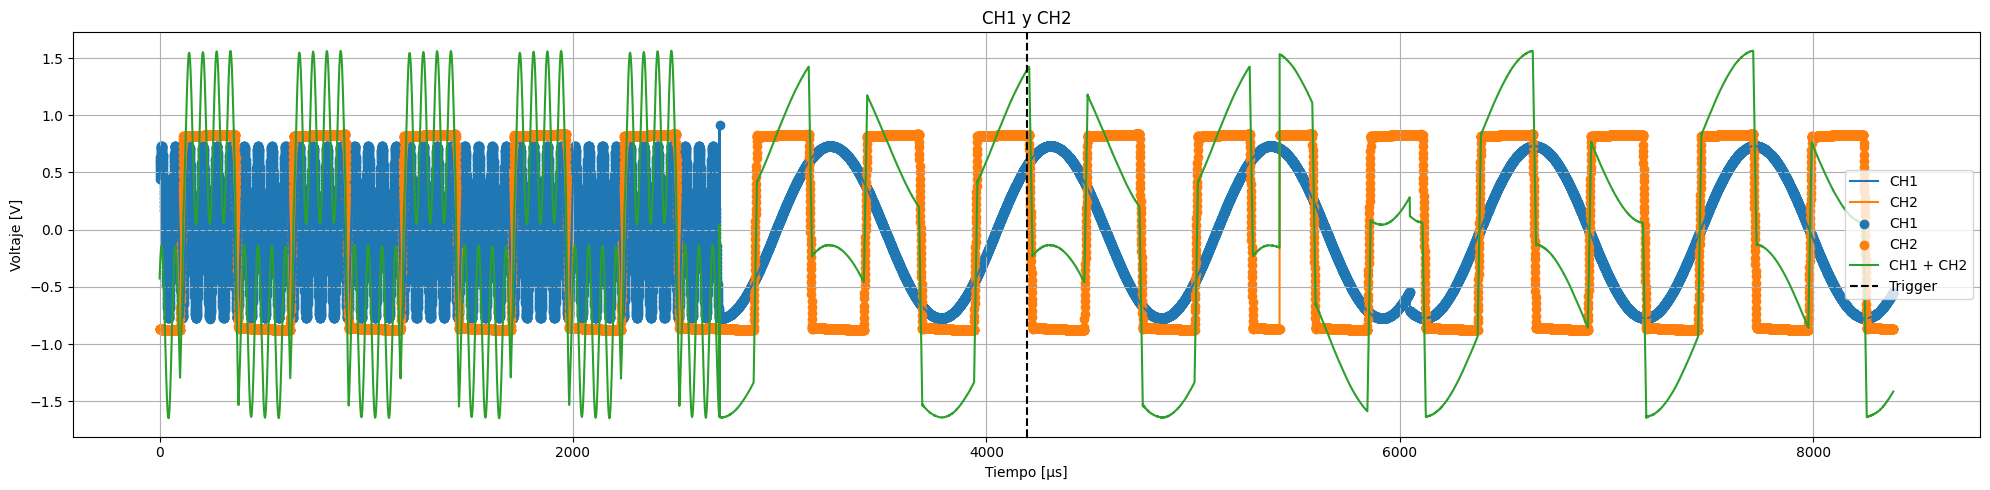

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time

dec = 2**6
y1, y2 = rp_gen.read_data(decimation=dec, trigger_level=0.1, trigger_source="CH1_PE", data_units='Volts', data_format='ascii')

# Tiempo
fs = 125e6 / dec
t = np.arange(len(y1)) / fs * 1e6  # en µs

# Plot
plt.figure(figsize=(20, 5))
plt.plot(t, y1, label='CH1')
plt.plot(t, y2, label='CH2')
plt.scatter(t, y1, label='CH1')
plt.scatter(t, y2, label='CH2')
plt.plot(t, y1 + y2, label='CH1 + CH2')
plt.axvline(x=t[8192], color='k', linestyle='--', label='Trigger')
plt.xlabel("Tiempo [µs]")
plt.ylabel("Voltaje [V]")
plt.title("CH1 y CH2")
plt.grid(True)
# plt.xlim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

array([0.000000e+00, 5.120000e-01, 1.024000e+00, ..., 8.387072e+03,
       8.387584e+03, 8.388096e+03], shape=(16384,))

In [7]:
rp_gen.stop_signal(channel=2)

In [4]:
print(len(y1), len(y2))

16384 16384


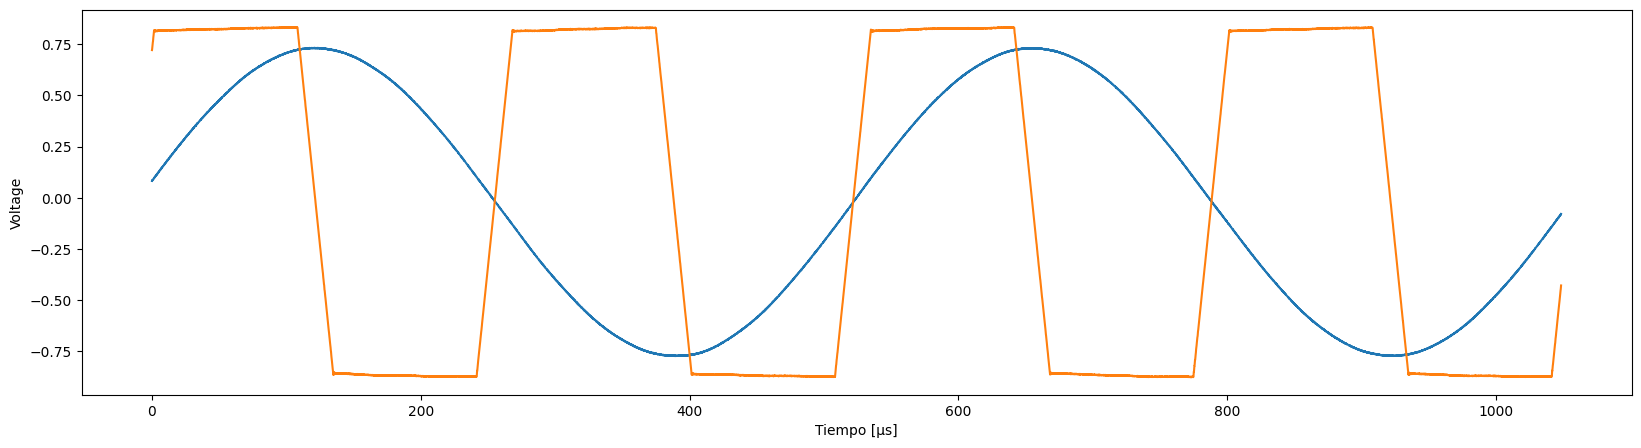

In [9]:
#!/usr/bin/python3

import sys
import rp_comm.redpitaya_scpi as scpi
import matplotlib.pyplot as plot
import struct

rp_s = scpi.scpi('rp-f0c5e4.local')

rp_s.tx_txt('ACQ:RST')
rp_s.tx_txt('ACQ:DATA:FORMAT BIN')
rp_s.tx_txt('ACQ:DATA:UNITS VOLTS')
rp_s.tx_txt('ACQ:DEC 1')

rp_s.tx_txt('ACQ:START')
rp_s.tx_txt('ACQ:TRIG:LEV 0')
rp_s.tx_txt('ACQ:TRIG CH1_PE')

while 1:
    rp_s.tx_txt('ACQ:TRIG:FILL?')
    if rp_s.rx_txt() == '1':
        break

rp_s.tx_txt('ACQ:SOUR1:DATA?')
buff_byte_1 = rp_s.rx_arb()
buff = [struct.unpack('!f',bytearray(buff_byte_1[i:i+4]))[0] for i in range(0, len(buff_byte_1), 4)]

rp_s.tx_txt('ACQ:SOUR2:DATA?')
buff_byte_2 = rp_s.rx_arb()
buff2 = [struct.unpack('!f',bytearray(buff_byte_2[i:i+4]))[0] for i in range(0, len(buff_byte_2), 4)]

fs = 125e6 / dec
t = np.arange(len(buff)) / fs * 1e6  # en µs

# Plot
plot.figure(figsize=(20, 5))
plt.plot(t, buff, label='CH1')
plt.plot(t, buff2, label='CH2')
plt.xlabel("Tiempo [µs]")
# plot.plot(buff)
# plot.plot(buff2)
plot.ylabel('Voltage')
# plot.xlim(0, 2500)
plot.show()